# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=107)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import average_precision_score
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit
from sklearn.metrics import mean_squared_error

In [4]:
best = 0
best_c = 1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=991)
for c in [0.0001, 0.001, 0.01, 0.1, 1]:
    svc = LinearSVC(max_iter=100000, C=c).fit(X_train, y_train)
    svc_pred = svc.decision_function(X_val)
    if best < roc_auc_score(y_val, svc_pred):
        best = roc_auc_score(y_val, svc_pred)
        best_c = c
    print('SVC ROC-AUC for c =', c, ':', roc_auc_score(y_val, svc_pred))

SVC ROC-AUC for c = 0.0001 : 0.8430118592570812
SVC ROC-AUC for c = 0.001 : 0.8456908098925152
SVC ROC-AUC for c = 0.01 : 0.8460256787219446
SVC ROC-AUC for c = 0.1 : 0.8459766735273939
SVC ROC-AUC for c = 1 : 0.8460011761246692


In [5]:
best_c

0.01

In [6]:
svc = LinearSVC(max_iter=100000, C=best_c).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)

На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

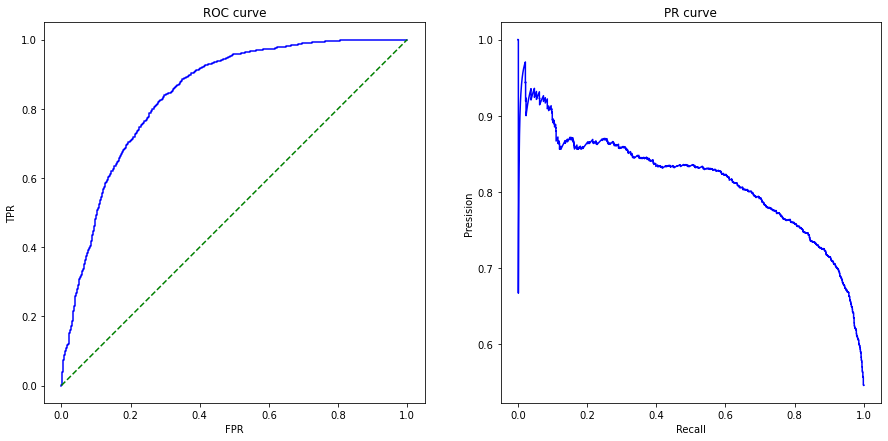

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

svc_tpr, svc_fpr, _ = metrics.roc_curve(y_test, svc_pred)

axs[0].plot(svc_tpr, svc_fpr, label='SVC', color='blue')
axs[0].plot([0, 1], [0, 1], label='Worst', linestyle='--', color='green')

axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_title('ROC curve')

svc_pr, svc_rec, _ = metrics.precision_recall_curve(y_test, svc_pred)

axs[1].plot(svc_rec, svc_pr, label='SVC', color='blue')

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Presision')
axs[1].set_title('PR curve')
plt.show()

In [8]:
print('SVC AUC-ROC:', roc_auc_score(y_test, svc_pred))
print('SVC AUC-PR:', metrics.average_precision_score(y_test, svc_pred))

SVC AUC-ROC: 0.8419020941710018
SVC AUC-PR: 0.8138069689120209


А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [9]:
log_reg = LogisticRegression().fit(X_train, y_train) # l2 by default
lr_pred = log_reg.decision_function(X_test)
print('Logistic Regression ROC-AUC:', roc_auc_score(y_test, lr_pred))

Logistic Regression ROC-AUC: 0.8419981325863678


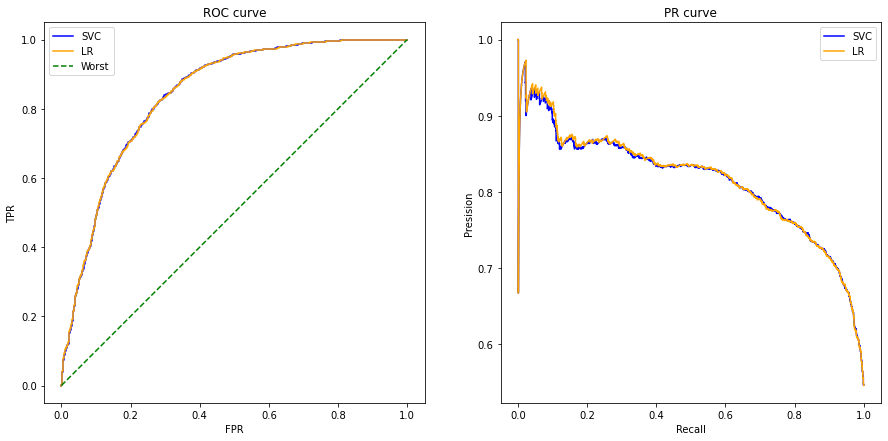

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

svc_tpr, svc_fpr, _ = metrics.roc_curve(y_test, svc_pred)
lr_tpr, lr_fpr, _ = metrics.roc_curve(y_test, lr_pred)

axs[0].plot(svc_tpr, svc_fpr, label='SVC', color='blue')
axs[0].plot(lr_tpr, lr_fpr, label='LR', color='orange')
axs[0].plot([0, 1], [0, 1], label='Worst', linestyle='--', color='green')

axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_title('ROC curve')
axs[0].legend()

svc_pr, svc_rec, _ = metrics.precision_recall_curve(y_test, svc_pred)
lr_pr, lr_rec, _ = metrics.precision_recall_curve(y_test, lr_pred)

axs[1].plot(svc_rec, svc_pr, label='SVC', color='blue')
axs[1].plot(lr_rec, lr_pr, label='LR', color='orange')

axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Presision')
axs[1].set_title('PR curve')
axs[1].legend()
plt.show()

In [11]:
print('SVC AUC-ROC:', roc_auc_score(y_test, svc_pred))
print('LR AUC-ROC:', roc_auc_score(y_test, lr_pred))
print('SVC AUC-PR:', metrics.average_precision_score(y_test, svc_pred))
print('LR AUC-PR:', metrics.average_precision_score(y_test, lr_pred))

SVC AUC-ROC: 0.8419020941710018
LR AUC-ROC: 0.8419981325863678
SVC AUC-PR: 0.8138069689120209
LR AUC-PR: 0.8152865921074282


Различия минимальны

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [12]:
from sklearn.svm import SVC

In [13]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [14]:
best = 0
best_c = 1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=991)
for c in [0.0001, 0.001, 0.01, 0.1, 1]:
    svc = SVC(kernel='linear', C=c, max_iter=10000).fit(X_train, y_train)
    svc_pred = svc.decision_function(X_val)
    if best < roc_auc_score(y_val, svc_pred):
        best = roc_auc_score(y_val, svc_pred)
        best_c = c
    print('SVC ROC-AUC for c =', c, ':', roc_auc_score(y_val, svc_pred))

SVC ROC-AUC for c = 0.0001 : 0.9413752847147954
SVC ROC-AUC for c = 0.001 : 0.9440693601978921
SVC ROC-AUC for c = 0.01 : 0.9454735449951425
SVC ROC-AUC for c = 0.1 : 0.9455960029716469
SVC ROC-AUC for c = 1 : 0.9456776416226498


In [15]:
svc = SVC(kernel='linear', C=best_c).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)

[Source helper](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html)

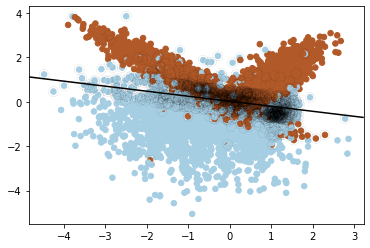

In [16]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc.decision_function(xy).reshape(XX.shape)

# sep lines
ax.contour(
    XX, YY, Z, colors="k", levels=[0], linestyles=["-"]
)

# support vectors
ax.scatter(
    svc.support_vectors_[:, 0],
    svc.support_vectors_[:, 1],
    s=100,
    linewidth=0.05,
    facecolors="none",
    edgecolors="k",
)

plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается  построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [17]:
log_reg = LogisticRegression().fit(X_train, y_train) # l2 by default
lr_pred = log_reg.predict_proba(X)[:, 1]

In [18]:
df = pd.DataFrame(lr_pred)
df['real'] = y

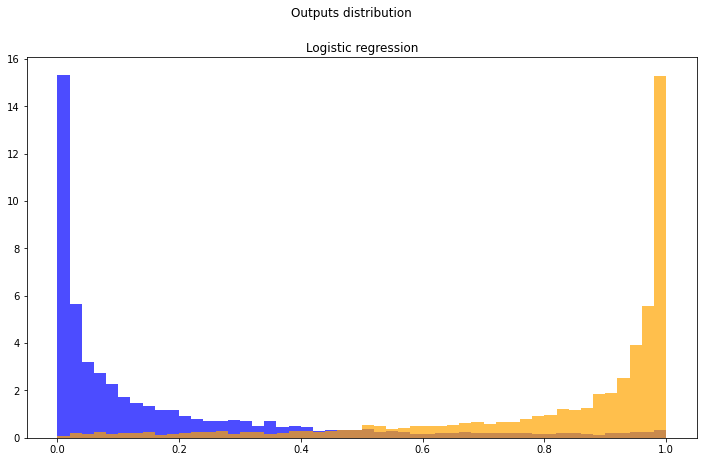

In [19]:
plt.figure(figsize=(12, 7))

plt.hist(df.loc[df['real'] == 0, 0], bins=50, color='blue', density='True', alpha = 0.7)
plt.hist(df.loc[df['real'] == 1, 0], bins=50, color='orange', density='True', alpha = 0.7)

plt.title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

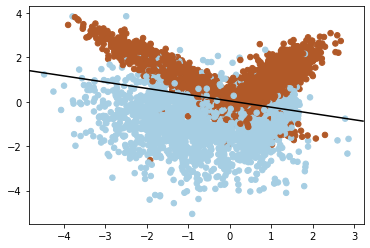

In [20]:
# However hyperplane pretty same with svc
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = log_reg.decision_function(xy).reshape(XX.shape)

# sep lines
ax.contour(
    XX, YY, Z, colors="k", levels=[0], linestyles=["-"]
)

plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [21]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = i / n_bins
        r = (i + 1) / n_bins
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)])) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

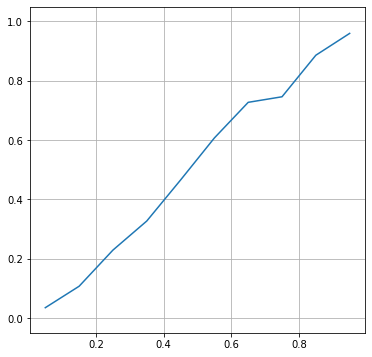

In [22]:
lr_pred = log_reg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, lr_pred)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [23]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=107)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [24]:
svc = SVC(kernel='linear', max_iter=10000).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

log_reg = LogisticRegression().fit(X_train, y_train) # l2 by default
lr_pred = log_reg.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


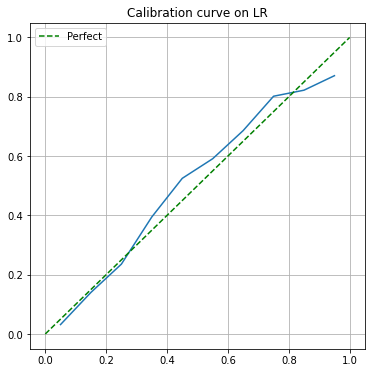

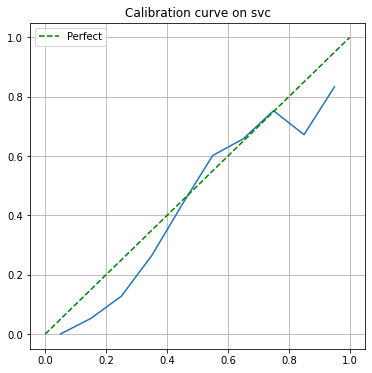

In [25]:
plot_calibration_curve(y_test, lr_pred)
plt.title('Calibration curve on LR')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.legend()
plot_calibration_curve(y_test, svc_pred)
plt.title('Calibration curve on svc')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.legend()
plt.show()

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


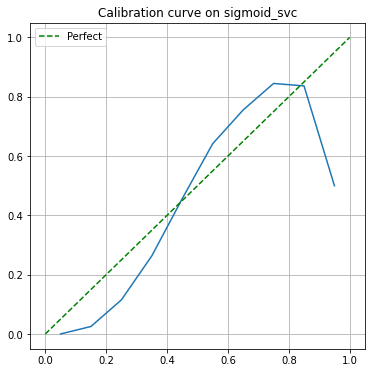

In [26]:
sigmoid_svc = CalibratedClassifierCV(svc, cv=3, method='sigmoid').fit(X_train, y_train)
svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, svc_pred)
plt.title('Calibration curve on sigmoid_svc')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.legend()
plt.show()

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [27]:
#your code here

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [28]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip

--2021-11-10 11:50:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K  --.-KB/s    in 0.1s    

2021-11-10 11:50:50 (3.06 MB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/

In [29]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [30]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [31]:
def TrainTestSplit(X, y):
    return train_test_split(X, y, test_size=0.25, random_state=777)

In [32]:
X = df.drop(columns=['duration', 'y'])
df['target'] = 0
df.loc[df['y'] == 'yes', 'target'] = 1
y = df['target']
X_train, X_test, y_train, y_test = TrainTestSplit(X, y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__:

In [33]:
data_config = {
    'numeric': set(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
                'nr.employed']),
    'categorical': set(['job', 'marital', 'education', 'default', 'housing',
                   'loan', 'contact', 'month', 'day_of_week', 'poutcome']),
}

In [34]:
def lr_with_endcoder(enc, df, y, range_):
    X = df.drop(columns=['duration', 'y'])
    
    start = time.time()

    X_train, X_test, y_train, y_test = TrainTestSplit(X, y)

    enc.fit(X_train[data_config['categorical']])
    X_cat = enc.transform(X[data_config['categorical']])
    scaler = StandardScaler().fit(X_train[data_config['numeric']])
    X_num = scaler.transform(X[data_config['numeric']])
    X = np.append(X_cat, X_num, axis=1)
    
    X_train, X_test, y_train, y_test = TrainTestSplit(X, y)

    lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
    lr_pred = lr.predict_proba(X_test)[:, 1]

    end = time.time()
    return (end - start) / range_, metrics.average_precision_score(y_test, lr_pred)

In [35]:
from sklearn.preprocessing import OrdinalEncoder
import time
time_taken = 0
range_ = 10
for _ in range(range_):
    time_for_1, auc_pr = lr_with_endcoder(OrdinalEncoder(), df, y, range_)
    time_taken += time_for_1 
print('auc-pr:', auc_pr)
print('Time taken: ', "{:.3f}".format(time_taken), 's', sep='')

auc-pr: 0.444635499526789
Time taken: 0.848s


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [36]:
from sklearn.preprocessing import OneHotEncoder

time_taken = 0
range_ = 10
for _ in range(range_):
    time_for_1, auc_pr = lr_with_endcoder(OneHotEncoder(sparse=False), df, y, range_)
    time_taken += time_for_1

print('auc-pr:', auc_pr)
print('Time taken: ', "{:.3f}".format(time_taken), 's', sep='')

auc-pr: 0.46186219186849026
Time taken: 2.208s


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.values_instead_ = dict()

    def mean_target_encoding(self, X, y):
        denominator = X.value_counts()
        numerators = X[y == 1].value_counts()
        res = dict()
        for value in denominator.keys():
            if not value in numerators.keys():
                numerators[value] = 0

            res.update({value: (numerators[value] / denominator[value])})

        return res

    def fit(self, X, y):
        X_res = pd.DataFrame(np.zeros(X.shape[0]))
        for col in X.columns:
            self.values_instead_.update(
                {col: self.mean_target_encoding(X[col], y)})

        return self

    def transform(self, X):
        res = X.copy()
        for i, col in enumerate(X.columns):
            res.loc[:, col] = 0
            for val in self.values_instead_[col]:
                res.loc[X[col] == val, col] = self.values_instead_[col][val]
            

        return res

In [38]:
def Normalize(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_test)

def PrepareData(X, y, mte=MeanTargetEncoding()):
    X_train, X_test, y_train, y_test = TrainTestSplit(X, y)

    X_cat_train = mte.fit_transform(X_train[data_config['categorical']], y_train)
    X_cat_test = mte.transform(X_test[data_config['categorical']])
    X_num_train, X_num_test = Normalize(X_train[data_config['numeric']], X_test[data_config['numeric']])
    return np.append(X_cat_train, X_num_train, axis=1), np.append(X_cat_test, X_num_test, axis=1), y_train, y_test

In [39]:
X_train, X_test, y_train, y_test = PrepareData(X, y)

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

print('auc-pr', metrics.average_precision_score(y_test, lr_pred))

auc-pr 0.4483064980757566


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь  на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [40]:
def MakeSomeNoize(y, percentage=7):
    z = np.random.randint(0, 1000, y.shape)
    a = y.copy()
    a[z < percentage] = 1 - y[z < percentage]
    return a

In [41]:
for p in [1, 2, 5, 7, 10, 20, 50]:
    X_train, X_test, y_train, y_test = PrepareData(X, y)
    y_train = MakeSomeNoize(y_train, p)

    lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
    lr_pred = lr.predict_proba(X_test)[:, 1]
    
    print('auc-pr for p = ', p, ': ', metrics.average_precision_score(y_test, lr_pred), sep='')
    print(mean_squared_error(lr_pred, y_test))

auc-pr for p = 1: 0.44817256671066086
0.08436303786301169
auc-pr for p = 2: 0.44866052620752483
0.08434478010298323
auc-pr for p = 5: 0.44760169375009795
0.08434666782109301
auc-pr for p = 7: 0.4478919725044419
0.08436270718040959
auc-pr for p = 10: 0.44764189695264567
0.08434679552096169
auc-pr for p = 20: 0.4478847619666595
0.08445222179694964
auc-pr for p = 50: 0.4470533228564265
0.08562074508871967


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [42]:
def PrepareDataV2(X, y, mte=MeanTargetEncoding()):
    X_train, X_test, y_train, y_test = TrainTestSplit(X, y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777)
    y_val = MakeSomeNoize(y_val)

    X_cat_train = mte.fit(X_val[data_config['categorical']], y_val).transform(X_train[data_config['categorical']])
    X_cat_test = mte.transform(X_test[data_config['categorical']])
    X_num_train, X_num_test = Normalize(X_train[data_config['numeric']], X_test[data_config['numeric']])
    return np.append(X_cat_train, X_num_train, axis=1), np.append(X_cat_test, X_num_test, axis=1), y_train, y_test

In [43]:
X_train, X_test, y_train, y_test = PrepareDataV2(X, y)

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

print('auc-pr for p = ', p, ': ', average_precision_score(y_test, lr_pred), sep='')
print(mean_squared_error(lr_pred, y_test))

auc-pr for p = 50: 0.4436237730092504
0.08470008292742098


А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [44]:
class SmoothTargetEncoding(MeanTargetEncoding):
    def __init__(self, C=0.1):
        self.C = 0.1
        self.values_instead_ = dict()

    def mean_target_encoding(self, X, y):
        denominator = X.value_counts()
        numerators = X[y == 1].value_counts()
        res = dict()
        for value in denominator.keys():
            if not value in numerators.keys():
                numerators[value] = 0

            res.update({value: ((numerators[value] + self.C + y.mean()) / (denominator[value] + self.C))})

        return res

In [45]:
X_train, X_test, y_train, y_test = PrepareData(X, y, SmoothTargetEncoding())

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

print('auc-pr', average_precision_score(y_test, lr_pred))

auc-pr 0.44825591187827635


In [46]:
for p in [1, 2, 5, 7, 10, 20, 50]:
    X_train, X_test, y_train, y_test = PrepareData(X, y, SmoothTargetEncoding())
    y_train = MakeSomeNoize(y_train, p)

    lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
    lr_pred = lr.predict_proba(X_test)[:, 1]
    
    print('auc-pr for p = ', p, ': ', average_precision_score(y_test, lr_pred), sep='')
    print(mean_squared_error(lr_pred, y_test))

auc-pr for p = 1: 0.44815165364754467
0.08436494828078386
auc-pr for p = 2: 0.44814425415452597
0.08436743736582088
auc-pr for p = 5: 0.4486941950465522
0.08433882950295586
auc-pr for p = 7: 0.44849261891126313
0.08432888450477002
auc-pr for p = 10: 0.4484003376219261
0.08435501793632284
auc-pr for p = 20: 0.44803227063231416
0.08449430454146308
auc-pr for p = 50: 0.4475422904481764
0.08568664380892863


In [47]:
X_train, X_test, y_train, y_test = PrepareDataV2(X, y, SmoothTargetEncoding())

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

print('auc-pr for p = ', p, ': ', average_precision_score(y_test, lr_pred), sep='')
print(mean_squared_error(lr_pred, y_test))

auc-pr for p = 50: 0.44410824245623787
0.08469235018832684


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше? Шо то, шо то, где это ваше переобучение то. Или мы это про ~1e-3



In [48]:
X['age'].value_counts().shape[0]

78

In [49]:
data_config['categorical'].add('age')
data_config['numeric'].remove('age')

In [50]:
X_train, X_test, y_train, y_test = PrepareDataV2(X, y, SmoothTargetEncoding())

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

print('auc-pr for p = ', p, ': ', average_precision_score(y_test, lr_pred), sep='')
print(mean_squared_error(lr_pred, y_test))

auc-pr for p = 50: 0.4437946850800899
0.08462444293222394


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз? Ожидаемо хуже

In [51]:
config_cat_to_num = {'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul',
                               'aug', 'sep', 'oct', 'nov', 'dec'],
                     'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri']}

In [52]:
for col in ['month', 'day_of_week']:
    for i, val in enumerate(config_cat_to_num[col]):
        X.loc[X[col] == val, col] = i

In [53]:
X_train, X_test, y_train, y_test = PrepareDataV2(X, y, SmoothTargetEncoding())

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

print('auc-pr for p = ', p, ': ', average_precision_score(y_test, lr_pred), sep='')
print(mean_squared_error(lr_pred, y_test))

auc-pr for p = 50: 0.443615474918857
0.08462351587414631


__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ скорость, уменьшение переобучения

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [54]:
# df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';') # не изменял


# Чтобы перед глазами было
data_config = {
    'numeric': set(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
                'nr.employed']),
    'categorical': set(['job', 'marital', 'education', 'default', 'housing',
                   'loan', 'contact', 'month', 'day_of_week', 'poutcome']),
}


df['target'] = 0
df.loc[df['y'] == 'yes', 'target'] = 1
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили? Мы же уже это делали

In [55]:
X = df.drop(columns=['duration', 'y'])
X_cat = OneHotEncoder(sparse=False).fit_transform(X[data_config['categorical']])
# scaler = StandardScaler().fit(X[data_config['numeric']])
X_num = X[data_config['numeric']]
X = np.append(X_cat, X_num, axis=1)
X.shape[1]

62

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [56]:
def TrainAndTest(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)
    lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
    lr_pred = lr.predict_proba(X_test)[:, 1]

    return metrics.average_precision_score(y_test, lr_pred)

ohe_auc_pr = TrainAndTest(X, y)
print('auc-pr:', ohe_auc_pr)

auc-pr: 0.44254067797020924


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [57]:
from sklearn.linear_model import Ridge

start = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

model = Ridge()
model.fit(X_train, y_train)

coefs_abs = np.absolute(model.coef_)
features = np.argpartition(coefs_abs, -40)[-40:]

end = time.time()
print('Time taken: ', "{:.3f}".format(end - start), 's; ', sep='')

Time taken: 0.092s; 


In [58]:
print('auc-pr:', TrainAndTest(X[:, features], y))

auc-pr: 0.44257759536720526


А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. А зачему я их везде маштабировал вообще?

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

![Лучше](http://risovach.ru/upload/2014/02/mem/snikers_43772304_big_.jpeg)

In [59]:
X = df.drop(columns=['duration', 'y'])
X_cat = OneHotEncoder(sparse=False).fit_transform(X[data_config['categorical']])
X_num = StandardScaler().fit_transform(X[data_config['numeric']])
X = np.append(X_cat, X_num, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

model = Ridge()
model.fit(X_train, y_train)

coefs_abs = np.absolute(model.coef_)
features = np.argpartition(coefs_abs, -40)[-40:]

print('auc-pr:', TrainAndTest(X[:, features], y))

auc-pr: 0.44569402785353057


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?
![Терминатор](https://www.meme-arsenal.com/memes/592db3ba7484fc926827693df8784f75.jpg)

In [60]:
X_cat = StandardScaler().fit_transform(X_cat)
X = np.append(X_cat, X_num, axis=1)
X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

model = Ridge()
model.fit(X_train, y_train)

coefs_abs = np.absolute(model.coef_)
features = np.argpartition(coefs_abs, -40)[-40:]

print('auc-pr:', TrainAndTest(X[:, features], y))

auc-pr: 0.4475394098527781


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [61]:
def t_stat(X, y):
    X_plus = X[y == 1]
    X_minus = X[y == 0]
    mu_plus = X_plus.mean()
    mu_minus = X_minus.mean()
    sigma_plus = X_plus.std()
    sigma_minus = X_minus.std()
    count_plus = X_plus.shape[0]
    count_minus = X_minus.shape[0]

    return np.absolute(mu_plus - mu_minus) / np.sqrt(
        (sigma_plus ** 2 * count_plus + sigma_minus ** 2 * count_minus) / (
            count_plus + count_minus))

In [62]:
start = time.time()

t_stats = np.array(t_stat(X[:, 0], y))
for i in range(1, X.shape[1]):
    t_stats = np.append(t_stats, t_stat(X[:, i], y))

features = np.argpartition(t_stats, -40)[-40:]

end = time.time()
print('Time taken: ', "{:.3f}".format(end - start), 's; ', sep='')
print('auc-pr:', TrainAndTest(X[:, features], y))

Time taken: 0.118s; 
auc-pr: 0.4519894727216218


### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [63]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y)

features = list(range(X_train.shape[1]))
best_auc_pr = TrainAndTest(X_train, y_train)
for _ in range(X_train.shape[1]):
    best_i = -1
    features_cur = features.copy()
    for i in features_cur:
        features.remove(i)
        new_auc_pr = TrainAndTest(X_train[:, features], y_train)

        if new_auc_pr >= best_auc_pr:
            best_auc_pr = new_auc_pr
            best_i = i

        features.append(i)
        
        if len(features) == 40:
            break

    if best_i < 0 or len(features) == 40:
        break
    
    features.remove(best_i)

end = time.time()

print('Time taken: ', "{:.3f}".format(end - start), 's; ', sep='')
print('auc-pr:', TrainAndTest(X[:, features], y))

Time taken: 333.017s; 
auc-pr: 0.44889532859281284


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [64]:
start = time.time()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y)

features = list()
global_best = 0
feat_best = list()
for _ in range(X_train.shape[1]):
    best_i = -1
    features_cur = set(range(X_train.shape[1])) - set(features)
    best_auc_pr = 0
    for i in features_cur:
        features.append(i)
        new_auc_pr = TrainAndTest(X_train[:, features], y_train)

        if new_auc_pr >= best_auc_pr:
            best_auc_pr = new_auc_pr
            best_i = i

        features.remove(i)
        
        if len(features) == 40:
            break

    if best_i < 0 or len(features) == 40:
        break
    
    features.append(best_i)

    if global_best < best_auc_pr:
        global_best = best_auc_pr
        feat_best = features.copy()

end = time.time()

print('Time taken: ', "{:.3f}".format(end - start), 's; ', sep='')
print('auc-pr:', TrainAndTest(X[:, features], y))

Time taken: 239.396s; 
auc-pr: 0.4405631910825599


In [65]:
print(global_best, feat_best, '; auc-pr:', TrainAndTest(X[:, feat_best], y))

0.4432505836814056 [53, 16, 61, 13, 37, 15, 55, 45, 57, 20, 21, 30, 46, 43, 22, 11, 9, 42, 7, 5, 32, 28, 26, 0, 14, 38] ; auc-pr: 0.43988972988417163


### Вывод

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** В данной моделе t-статистика была лучшей, и заняла очень мало времени

1. При отскаливании всех признаков вариант с обучением линейной модели был быстр и не плох в качестве. Однако такой вариант может не подойти в случае сложной задаче.
2. t-статистика была лучшей по времени, хотя немного проиграла 1 варианту в скорости. Этот вариант плох тем, что сильно зависит от функции и при не подходящих под неё параметрах может быть и хуже других.
3. Очень долгий метод, однако получилось так, что только 2 признак давал качество лучше, чем любая другая модель, что довольно странно, видимо модель переобучалась (либо же эта метрика не подходила). У метода есть свои плюсы: можно забить на всё и применять в любой модельке без особого изменения.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [66]:
from sklearn.model_selection import KFold

X = df.drop(columns=['duration', 'y'])
X_cat = OneHotEncoder(sparse=False).fit_transform(X[data_config['categorical']])
X_num = StandardScaler().fit_transform(X[data_config['numeric']])
X = np.append(X_cat, X_num, axis=1)

kf = KFold(n_splits=5, random_state=500, shuffle=True)
kf.get_n_splits(X)

5

In [67]:
def TrainAndPredict(X, y, train_index, test_index, c=1.):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr = LogisticRegression(max_iter=10000, C=c).fit(X_train, y_train)
    return lr.predict(X_test), lr.predict_proba(X_test)[:, 1]

In [68]:
profit = 0
proceeds = 0

for train_index, test_index in kf.split(X):
    lr_pred, lr_proba = TrainAndPredict(X, y, train_index, test_index)
    profit += (lr_proba[lr_pred == 1] * 10 - 1).sum()
    proceeds += (lr_proba[lr_pred == 1] * 10).sum()

print('Mean profit =', profit / 5, '\n'
      'Mean proceed =', proceeds / 5, '\n'
      'Mean pay for call center =', (proceeds - profit) / 5)

Mean profit = 1871.5566116410282 
Mean proceed = 2195.9566116410283 
Mean pay for call center = 324.4


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [69]:
profit = 0
proceeds = 0

for train_index, test_index in kf.split(X):
    lr_pred, lr_proba = TrainAndPredict(X, y, train_index, test_index)
    profit += (lr_proba[lr_pred == 1] * np.random.rand(lr_pred.sum()) * 20 - 1).sum()
    proceeds += (lr_proba[lr_pred == 1] * np.random.rand(lr_pred.sum()) * 20).sum()

print('Mean profit =', profit / 5, '\n'
      'Mean proceed =', proceeds / 5, '\n'
      'Mean pay for call center =', (proceeds - profit) / 5)

Mean profit = 1898.3462304626107 
Mean proceed = 2179.479191362139 
Mean pay for call center = 281.1329608995282


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [71]:
c_values = np.logspace(-3, 2, num=10)
profits = []
profit_error = []
for c in c_values:
    profit = 0
    err = []
    for train_index, test_index in kf.split(X):
        lr_pred, lr_proba = TrainAndPredict(X, y, train_index, test_index, )
        profit_ = (lr_proba[lr_pred == 1] * np.random.rand(lr_pred.sum()) * 20 - 1).sum()
        err.append(profit_)
        profit += profit_
    
    profit_error.append(np.std(err))
    profits.append(profit / 5)

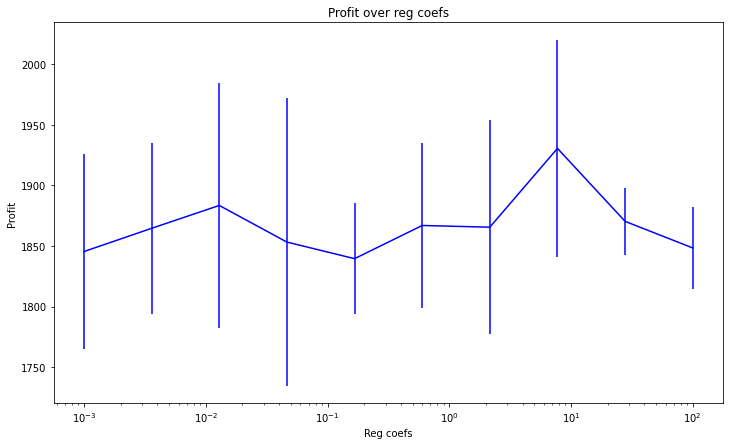

In [72]:
plt.figure(figsize=(12, 7))
plt.errorbar(c_values, profits, profit_error, color='blue')
plt.xscale('log')
plt.xlabel('Reg coefs')
plt.ylabel('Profit')
plt.title('Profit over reg coefs')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы? Ну как-то не особо закономерно. Думаю вся проблема в рандоме оплаты.

In [73]:
print(c_values[np.argmax(profits)])
for _ in range(5):
    profits = []
    profit_error = []
    for c in np.logspace(0.001, 3.0, num=10):
        profit = 0
        err = []
        for train_index, test_index in kf.split(X):
            lr_pred, lr_proba = TrainAndPredict(X, y, train_index, test_index, )
            profit_ = (lr_proba[lr_pred == 1] * np.random.rand(lr_pred.sum()) * 20 - 1).sum()
            err.append(profit_)
            profit += profit_

        profit_error.append(np.std(err))
        profits.append(profit / 5)

    print(c_values[np.argmax(profits)])

7.742636826811277
27.825594022071257
100.0
0.003593813663804626
0.003593813663804626
0.003593813663804626


__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ очевидно precision, при любом recall можно взять сколько угодно плохих данных, и по итогу звонок будет стоить больше, чем оплачиваться. А precision даёт нам ту часть звонков, которые реально оплатяться и если мало, то мы знаем что обзвон убыточен.



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [74]:
lr_probas = []
for train_index, test_index in kf.split(X):
    _, lr_proba = TrainAndPredict(X, y, train_index, test_index)
    lr_probas.append(lr_proba)

In [75]:
profits = []
profit_error = []
bin_values = np.linspace(0, 1, 101)
for bin in bin_values:
    profit = 0
    err = []
    for j in range(5):
        profit_ = (lr_probas[j][lr_probas[j] > bin] * np.random.rand(
            len(lr_probas[j][lr_probas[j] > bin])) * 20 - 1).sum()
        
        err.append(profit_)
        profit += profit_

    profit_error.append(np.std(err))
    profits.append(profit / 5)

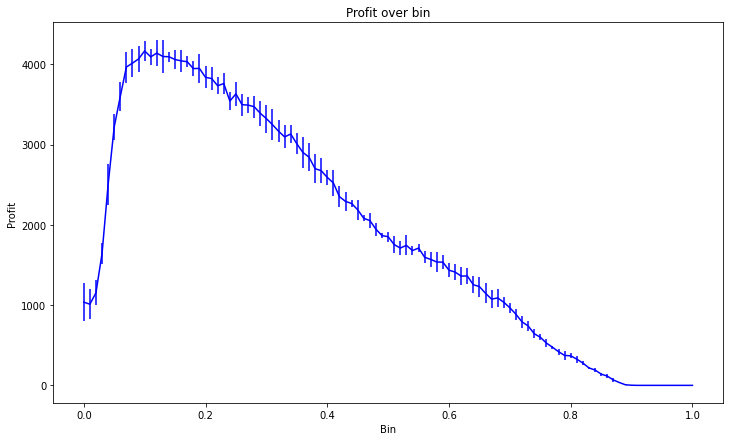

In [76]:
plt.figure(figsize=(12, 7))
plt.errorbar(bin_values, profits, profit_error, color='blue')
plt.xlabel('Bin')
plt.ylabel('Profit')
plt.title('Profit over bin')
plt.show()

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ На самом деле скорее всего ответ 0.11 (0.1), потому что матожидание таких звонков (и всех у кого больше) не ниже 0.<br>$E[profit] = p * E[rand[0;20]] - 1 = 10p - 1 \ge 0\\ p\ge 0.1$.

In [77]:
bin = bin_values[np.argmax(profits)]

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [78]:
from sklearn.metrics import precision_recall_curve

precision_ = [[]] * 5
recall_ = [[]] * 5
max_size = 0
for j, (train_index, test_index) in enumerate(kf.split(X)):
    precision_[j], recall_[j], _ = precision_recall_curve(y.loc[test_index], lr_probas[j])
    if max_size < recall_[j].shape[0]:
        max_size = recall_[j].shape[0]

precision = []
recall = []
for j in range(5):
    idx = -lr_probas[j][lr_probas[j] > bin].shape[0]
    precision.append(precision_[j][idx])
    recall.append(recall_[j][idx])

mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
std_precision = np.std(precision)
std_recall = np.std(recall)

print('precision:\n  mean: ', mean_precision, '\n  std:', std_precision,
      '\nrecall:\n  mean: ', mean_recall, '\n  std:', std_recall, sep='')

precision:
  mean: 0.3148506365679292
  std:0.012611920756936868
recall:
  mean: 0.6603060207962506
  std:0.021109271354615194


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [79]:
mean_auc = 0

for j in range(5):
    idx = recall_[j][recall_[j] > 0.5].shape[0]
    mean_auc += 2 * metrics.auc(recall_[j][:idx], precision_[j][:idx]) / 5

mean_auc

0.2567861567780288

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Чахоибили с гречкой из вкусвилла :)
<br>ПС для разнообразия можно, а так не советую

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:__ Поговорили про работу, МО, дедлайны, СЛТ :)
![Терминатор](meeting.jpg)